In [114]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [115]:
ortlama=[]
enyuk=[]
enkuc=[]
meanofoverexp=[]
#READ IMAGES FROM FOLDER
def read_all_images(x):
    images=[]
    folder=r'C:\Users\yigit\Desktop\uuu\\'+ str(x) +''
    
    
    for filename in os.listdir(folder):
        img=Image.open(os.path.join(folder,filename)).convert("RGB")
        #img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        img=np.array(img)
 
        if img is not None:
            images.append(img)
            
    return images


In [116]:
#ACCORDING TO IMG MEANS DETERMINE TAG
def img_estim(x):
  
    for i in range(x):
    
        if (enkuc[i]>50 and meanofoverexp[i]>140 ):
    
            if( enyuk[i]>=enkuc[i]*130/100):
                print(i+1,'Overexpo+Yansimali')
            else:
                print(i+1,'Overexpo')

        elif (enyuk[i]>55) or(ortlama[i]>48) or (enyuk[i]>=enkuc[i]*155/100)    :
            print(i+1,'YANSIMALI')
            
        elif((ortlama[i]>40 and enyuk[i]>=enkuc[i]*127/100)):
            print(i+1,'YANSIMALI OLABILIR')
        else:
            print(i+1,'UYGUN')

In [117]:
    
#SPLIT COMING IMAGE TO 4 
def into_four(img):
    height = img.shape[0]
    width = img.shape[1]

    width_cutoff = width // 2
    left1 = img[:, :width_cutoff]
    right1 = img[:, width_cutoff:]


    img = cv2.rotate(left1, cv2.ROTATE_90_CLOCKWISE)

    height = img.shape[0]
    width = img.shape[1]

    width_cutoff = width // 2
    l1 = img[:, :width_cutoff]
    l2 = img[:, width_cutoff:]

    l1 = cv2.rotate(l1, cv2.ROTATE_90_COUNTERCLOCKWISE)

    #cv2.imwrite(r'C:\Users\yigit\Desktop\one_horisont_1.jpg', l1)
    print('sol alt',np.mean(l1))

    l2 = cv2.rotate(l2, cv2.ROTATE_90_COUNTERCLOCKWISE)

    #cv2.imwrite(r'C:\Users\yigit\Desktop\one_horisont_2.jpg', l2)
    print('sol yukarı' ,np.mean(l2))


    img = cv2.rotate(right1, cv2.ROTATE_90_CLOCKWISE)

    height = img.shape[0]
    width = img.shape[1]

    width_cutoff = width // 2
    r1 = img[:, :width_cutoff]
    r2 = img[:, width_cutoff:]

    r1 = cv2.rotate(r1, cv2.ROTATE_90_COUNTERCLOCKWISE)

    #cv2.imwrite(r'C:\Users\yigit\Desktop\second_vhorisont_1.jpg', r1)
    print('sağ alt' ,np.mean(r1))

    r2 = cv2.rotate(r2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    #cv2.imwrite(r'C:\Users\yigit\Desktop\second_horisont_2.jpg', r2)
    print('sağ yukarı' ,np.mean(r2))
    
    holder=[]
    holder.append(np.mean(l1))
    holder.append(np.mean(l2))
    holder.append(np.mean(r1))
    holder.append(np.mean(r2))
    global enyuk
    enyuk.append(np.amax(holder))
    enkuc.append(np.amin(holder))
    


In [118]:
    
def crops_like_donut(img):
 
    img=np.array(img)
    hh, ww = img.shape[:2]
    hh2 = hh // 2
    ww2 = ww // 2

    x,y,_=img.shape
   
    # define circles
    radius1 = (x//2)-130
    radius2 = x//2
 
    xc = hh // 2
    yc = ww // 2

    # draw filled circles in white on black background as masks
    mask1 = np.zeros_like(img)
    mask1 = cv2.circle(mask1, (xc,yc), radius1, (255,255,255), -1)
    mask2 = np.zeros_like(img)
    mask2 = cv2.circle(mask2, (xc,yc), radius2, (255,255,255), -1)

    # subtract masks and make into single channel
    mask = cv2.subtract(mask2, mask1)

    # put mask into alpha channel of input

    result = cv2.bitwise_and(img, mask)

    print('tam cember mean',np.mean(result))
    global ortlama
    ortlama.append(np.mean(result))
    into_four(result)

In [119]:

#CALCULATE AVERAGE COLOR WITH CROPPING IMAGE WITHOUT INCLUDING BLACK PARTS
#CHNAGE BLACK MASK (which is 0) WITH AVERAGE COLOR   
def remove_black_perimeters(image):
    y=400
    x=25
    h=200
    w=100
    crop_img = image[y:y+h, x:x+w]

    avg_color_per_row = np.average(crop_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)

    image_copy = image.copy()
    black_pixels_mask = np.all(image == [0, 0, 0], axis=-1)

    image_copy[black_pixels_mask] = avg_color
    #image_copy[non_black_pixels_mask] = [0, 0, 0]
    
    img = Image.fromarray(image_copy, 'RGB')
    npImage=np.array(img)
    crops_like_donut(img)

In [120]:
#CROP RETINA IMAGES PROPERLY   
def get_rad_andcrop(planet):
    gray=cv2.cvtColor(planet,cv2.COLOR_BGR2GRAY)
    img=cv2.medianBlur(gray,5)
    height,width,_= planet.shape
  
    mask = np.zeros((height,width), np.uint8)

    cimg=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    circles=cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,700,param2=15,minRadius=0,maxRadius=0)
    circles=np.uint16(np.around(circles))
    for i in circles[0,]:
        x=i[0]
        y=i[1]
        z=i[2]
        #cv2.circle(planet,(x,y),z,(0,255,0),5)
        #cv2.circle(planet,(x,y),1,(0,255,0),2)
        circle_img = cv2.circle(mask,(x,y),z,(255,255,255),thickness=-1)


    masked_data = cv2.bitwise_and(planet, planet, mask=mask)
    _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)
    contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    x,y,w,h = cv2.boundingRect(contours[0])

    crop = masked_data[y:y+h,x:x+w]
   
    y=300
    x=50

    h=h-600
    w=w-100
    
    crop1 = crop[y:y+h,x:x+w]
    print('ortadan croplu mean',np.mean(crop1))
    meanofoverexp.append(np.mean(crop1))
    remove_black_perimeters(crop)
    



In [121]:
images=read_all_images('overexpo')
for i in range(len(images)):
    print(i+1)
    get_rad_andcrop(images[i])
    

img_estim(len(images))

1
ortadan croplu mean 167.55360753086077
tam cember mean 79.4936030620519
sol alt 74.97029444472669
sol yukarı 75.95015534204826
sağ alt 84.31541759266301
sağ yukarı 82.72261270795649
2
ortadan croplu mean 142.88921613467377
tam cember mean 57.90445189695012
sol alt 56.67145582440852
sol yukarı 60.02513187321557
sağ alt 57.85265238302497
sağ yukarı 57.06776868986543
3
ortadan croplu mean 176.96737987570845
tam cember mean 53.489625093005856
sol alt 54.33400944112036
sol yukarı 53.425554672118736
sağ alt 52.24549852880725
sağ yukarı 53.95420004939091
4
ortadan croplu mean 186.59109728194125
tam cember mean 59.36978892529682
sol alt 61.880622940513355
sol yukarı 60.621534313407324
sağ alt 58.23269455442331
sağ yukarı 56.75462837386492
1 Overexpo
2 Overexpo
3 Overexpo
4 Overexpo


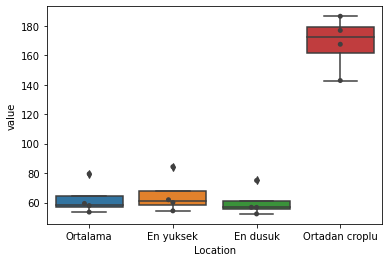

In [122]:

df1 = pd.DataFrame(ortlama, columns=['Mean Values']).assign(Location='Ortalama')
df2 = pd.DataFrame(enyuk, columns=['Mean Values']).assign(Location='En yuksek')
df3 = pd.DataFrame(enkuc, columns=['Mean Values']).assign(Location='En dusuk')
df4 = pd.DataFrame(meanofoverexp, columns=['Mean Values']).assign(Location='Ortadan croplu')


cdf = pd.concat([df1, df2 ,df3 ,df4])    
mdf = pd.melt(cdf, id_vars=['Location'])

ax = sns.swarmplot(x="Location", y="value", data=mdf,color='0.25')    
ax = sns.boxplot(x="Location", y="value",  data=mdf)    
plt.show()